# Prévision de la mortalité (France, 2000–2022)

## I - Introduction :

### 1 - Contexte du projet :

L’analyse de la mortalité constitue un enjeu majeur pour les systèmes de retraite, 
les assurances vie, les politiques publiques de santé et la planification 
socio-économique. Dans le contexte français, comprendre l’évolution de la 
mortalité sur la période 2000–2022 est particulièrement important, car cette 
période inclut des dynamiques démographiques complexes : vieillissement 
accéléré de la population, progrès médicaux, chocs sanitaires tels que la 
pandémie de Covid-19, ainsi que des transformations structurelles affectant 
les comportements de santé.

### 2 - Objectifs du projet :

Ce projet vise à étudier ces évolutions en comparant deux grandes familles de 
méthodes de prévision :

1. **Les modèles statistiques classiques**, représentés par le modèle 
   de référence en démographie actuarielle : le **modèle de Lee–Carter**, 
   largement utilisé pour projeter les taux de mortalité grâce à une 
   structure factorielle simple et interprétable.

2. **Les approches modernes d’apprentissage automatique (Machine Learning)**, 
   incluant **Random Forest**, **XGBoost**, **SVM** et **MLP**, capables 
   de modéliser des relations non linéaires, d’intégrer des interactions 
   complexes et potentiellement de capturer des signaux subtils que les 
   modèles traditionnels ne détectent pas.

L’objectif général de ce travail est donc d’évaluer la capacité des modèles 
de Machine Learning à améliorer la qualité des prévisions de mortalité 
par rapport au modèle de Lee–Carter, en termes de précision, de stabilité 
et de robustesse face aux variations temporelles.

### 3 - Problématique du projet :

> **Les approches du Machine Learning permettent-elles réellement d’améliorer la qualité des prévisions de mortalité par rapport aux modèles classiques, en particulier le modèle de Lee–Carter ?**

Cette problématique pose la question centrale de la performance prédictive, de 
la pertinence méthodologique et de la capacité de généralisation des différents 
modèles appliqués à la mortalité française entre 2000 et 2022.

## I - Construction des données :

 Les données exploitées dans cette étude proviennent de la Human Mortality Database
 (https://www.mortality.org), plateforme spécialisée dans la collecte et la diffusion de
 statistiques démographiques longitudinales. Après inscription, nous avons pu accéder à deux
 fichiers essentiels concernant la population française.

### 1 -  Prétraitement de la base des décès (Death counts) :

La première base téléchargée concerne le **nombre annuel de décès** selon trois dimensions :

- **Year** : année civile *(t)*
- **Age** : âge exact *(x)*, variant de **0** à **100** ans
- **Sexe** : *(i = Female, Male)*, et **Total**

Après copie manuelle depuis la plateforme vers un **fichier texte** via *Notepad*, les données ont été importées dans **Excel**.  
Nous avons structuré la base selon les variables suivantes :

- **Year** : année civile *(t)*
- **Age** : âge exact *(x)*
- **D_F** : nombre de décès **féminins**
- **D_H** : nombre de décès **masculins**
- **D_Tot** : nombre de décès **totaux**

Cette base couvre initialement la période **1860–2022**, mais nous avons restreint l’échantillon à la période **2000–2022** pour des raisons de qualité, de modernité statistique et de pertinence actuarielle.


### 2 -  Prétraitement de la base des expositions (Exposure-to-risk) :

La deuxième base contient les **expositions au risque de décès**, c’est-à-dire le nombre moyen d’individus vivants à chaque âge et pour chaque année.  
Les variables sont structurées de manière identique :

- **Year** : année civile *(t)*
- **Age** : âge exact *(x)*
- **E_F** : exposition **féminine**
- **E_H** : exposition **masculine**
- **E_Tot** : exposition **totale** (somme des deux sexes)

Les données ont été importées dans un second fichier Excel à partir d’un fichier texte brut, suivant le même protocole que pour les décès.  
La période analysée est également restreinte à **2000–2022**.


### 3 - Fusion des deux bases :

Les deux bases ont été fusionnées par **jointure interne** sur les clés communes :

**Year = t**    et    **Age = x**

Le jeu de données final comporte donc les colonnes suivantes :

- **Year**, **Age**
- **E_F**, **E_H**, **E_Tot**
- **D_F**, **D_H**, **D_Tot**


### 4 - Construction des taux de mortalité :

À partir des données fusionnées, nous construisons les **taux de mortalité centraux** :

- **Par sexe** :

m(t, x, i) = D(t, x, i)\E(t, x, i) avec i dans F, H

- **Agrégé** :

m(t, x) = D(t, x)\E(t, x)

Ces taux m_F, m_H et m_Tot constituent la base d’entrée pour notre étude.

In [1]:
import pandas as pd
import numpy as np
!pip install openpyxl
%pip install tabulate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

Note: you may need to restart the kernel to use updated packages.


In [2]:

# 1. Chemin vers le fichier Excel (la "base jaune" fusionnée)
# 👉 adapte le chemin/nom selon ton projet
file_path = "Mortalite France .xlsx"

# 2. Importer les données
df = pd.read_excel(file_path)

# 3. Afficher l'entête pour vérifier
print("Colonnes disponibles dans le fichier :")
print(df.columns.tolist())
print("\nAperçu des premières lignes :")
print(df.head())

# 4. Harmoniser les noms de colonnes (si besoin)
#    On gère les cas 'Année' / 'Annee', etc.
df = df.rename(columns={
    "Année": "Year",
    "Annee": "Year",
    "annee": "Year",
    "AGE": "Age",
    "age": "Age"
})

# 5. Sélectionner et ordonner les colonnes utiles
colonnes_attendues = ["Year", "Age", "E_F", "E_H", "E_Tot", "D_F", "D_H", "D_Tot"]

# Vérification des colonnes manquantes
missing = [c for c in colonnes_attendues if c not in df.columns]
if missing:
    print("\n⚠️ Attention : colonnes manquantes dans le fichier :", missing)

# On ne garde que les colonnes existantes parmi celles attendues
colonnes_finales = [c for c in colonnes_attendues if c in df.columns]
df = df[colonnes_finales].copy()

# 6. Calcul des taux de mortalité
# m_F(t,x) = D_F(t,x) / E_F(t,x)
# m_H(t,x) = D_H(t,x) / E_H(t,x)
# m_Tot(t,x) = D_Tot(t,x) / E_Tot(t,x)
# On évite la division par zéro avec np.where

if {"D_F", "E_F"}.issubset(df.columns):
    df["m_F"] = np.where(df["E_F"] > 0, df["D_F"] / df["E_F"], np.nan)

if {"D_H", "E_H"}.issubset(df.columns):
    df["m_H"] = np.where(df["E_H"] > 0, df["D_H"] / df["E_H"], np.nan)

if {"D_Tot", "E_Tot"}.issubset(df.columns):
    df["m_Tot"] = np.where(df["E_Tot"] > 0, df["D_Tot"] / df["E_Tot"], np.nan)

# 7. Trier par année et âge
if {"Year", "Age"}.issubset(df.columns):
    df = df.sort_values(["Year", "Age"]).reset_index(drop=True)

# 8. Afficher l'entête de la base finale
pd.set_option("display.max_columns", None)
print("\nAperçu de la base finale avec les taux :")
print(df.head())
print("\nColonnes :", df.columns.tolist())

# 9. Sauvegarder la base propre (optionnel mais recommandé)
output_excel = "mortalite_france_2000_2022_processed.xlsx"
output_csv = "mortalite_france_2000_2022_processed.csv"

df.to_excel(output_excel, index=False)
df.to_csv(output_csv, index=False)

print(f"\n✅ Fichiers enregistrés :\n- {output_excel}\n- {output_csv}")


Colonnes disponibles dans le fichier :
['Annee', 'Age', 'E_F', 'E_H', 'E_Tot', 'D_F', 'D_H', 'D_Tot']

Aperçu des premières lignes :
   Annee  Age        E_F        E_H      E_Tot   D_F   D_H  D_Tot
0   2000    0  362246.66  380982.78  743229.43  1425  1992   3417
1   2000    1  354288.33  371892.85  726181.18   149   158    307
2   2000    2  350344.21  368268.07  718612.28    69    96    165
3   2000    3  351312.27  370227.17  721539.45    57    82    139
4   2000    4  353345.34  371065.57  724410.91    46    65    111

Aperçu de la base finale avec les taux :
   Year  Age        E_F        E_H      E_Tot   D_F   D_H  D_Tot       m_F  \
0  2000    0  362246.66  380982.78  743229.43  1425  1992   3417  0.003934   
1  2000    1  354288.33  371892.85  726181.18   149   158    307  0.000421   
2  2000    2  350344.21  368268.07  718612.28    69    96    165  0.000197   
3  2000    3  351312.27  370227.17  721539.45    57    82    139  0.000162   
4  2000    4  353345.34  371065.57  724

## II - Validation des données :

### 1 - Qualité des données :

Il est important de souligner que les fichiers extraits de la *Human Mortality Database* sont déjà :

- **nettoyés** : pas de doublons, pas de formats incohérents
- **cohérents** : les valeurs d’exposition et de décès sont compatibles et correctement agrégées
- **fiables** : les estimations sont produites selon une méthodologie rigoureuse conforme aux normes démographiques internationales

Aucune anomalie n’a été détectée lors de l’importation ni dans le traitement des variables,
ce qui rend la base directement exploitable pour des travaux de modélisation.


### 2 - Validation finale de la base de données :

In [3]:

# 1. Charger la base finale (feuille "Mortality")
# 👉 adapte le chemin et le nom de fichier si besoin
file_path = "mortalite_france_2000_2022_processed.xlsx"

print("Aperçu des premières lignes :")
print(df.head())

print("\nColonnes disponibles :")
print(df.columns.tolist())

# 2. Harmoniser les noms si nécessaire
df = df.rename(columns={
    "Année": "Annee",
    "Année ": "Annee",
    "Annee": "Year",
    "age": "Age",
    "E_M": "E_H"   # si tu utilises E_H dans le fichier, on le renomme en E_M pour être cohérent avec le texte
})

# 3. Vérifier la période temporelle et la plage d’âges
annee_min, annee_max = df["Year"].min(), df["Year"].max()
age_min, age_max = df["Age"].min(), df["Age"].max()

print(f"\nPériode couverte : {annee_min} – {annee_max}")
print(f"Plage d'âges couverte : {age_min} – {age_max}")

# 4. Vérifier unicité (Year, Age)
nb_lignes = len(df)
nb_uniques = df[["Year", "Age"]].drop_duplicates().shape[0]
print(f"\nNombre total de lignes : {nb_lignes}")
print(f"Nombre de couples (Annee, Age) uniques : {nb_uniques}")

if nb_lignes == nb_uniques:
    print("✅ Chaque ligne correspond à une combinaison unique (Annee, Age).")
else:
    print("⚠️ Des doublons existent sur (Annee, Age). À vérifier.")

# 5. Vérifier égalités d’agrégation
checks = {}

if {"E_F", "E_H", "E_Tot"}.issubset(df.columns):
    diff_E = (df["E_Tot"] - (df["E_F"] + df["E_H"])).abs().max()
    checks["E_Tot = E_F + E_H (max écart)"] = diff_E

if {"D_F", "D_H", "D_Tot"}.issubset(df.columns):
    diff_D = (df["D_Tot"] - (df["D_F"] + df["D_H"])).abs().max()
    checks["D_Tot = D_F + D_H (max écart)"] = diff_D

print("\nVérification des égalités d'agrégation :")
for k, v in checks.items():
    print(f"- {k} : {v}")

# 6. Vérifier absence de valeurs manquantes
na_counts = df.isna().sum()
print("\nNombre de valeurs manquantes par colonne :")
print(na_counts)

# 7. Vérifier la cohérence des types et la positivité
print("\nTypes des colonnes :")
print(df.dtypes)

# Variables censées être entières
int_vars = ["Annee", "Age", "D_F", "D_H", "D_Tot"]
for col in int_vars:
    if col in df.columns:
        non_int = ((df[col] % 1) != 0).sum()
        print(f"\n{col} : {non_int} valeurs non entières détectées.")

# Variables censées être positives
pos_vars = ["E_F", "E_H", "E_Tot", "m_F", "m_H", "m_Tot"]
for col in pos_vars:
    if col in df.columns:
        min_val = df[col].min()
        print(f"{col} : min = {min_val}")

# 8. Petit résumé automatique
print("\n📌 Résumé :")
if (annee_min == 2000) and (annee_max == 2022):
    print("- Période conforme : 2000–2022.")
else:
    print("- ⚠️ Période différente de 2000–2022, à vérifier.")

if (age_min == 0) and (age_max == 100):
    print("- Plage d’âges conforme : 0–100 ans.")
else:
    print("- ⚠️ Plage d’âges différente de 0–100 ans, à vérifier.")

if df.isna().sum().sum() == 0:
    print("- Aucune valeur manquante détectée.")
else:
    print("- ⚠️ Des valeurs manquantes existent, à traiter.")

if checks:
    ok_agg = all(v == 0 for v in checks.values())
    if ok_agg:
        print("- Égalités d’agrégation (E_Tot, D_Tot) respectées.")
    else:
        print("- ⚠️ Écarts dans les égalités d’agrégation, à examiner.")

print("- La base est prête pour la modélisation (si tous les voyants sont au vert ci-dessus).")


Aperçu des premières lignes :
   Year  Age        E_F        E_H      E_Tot   D_F   D_H  D_Tot       m_F  \
0  2000    0  362246.66  380982.78  743229.43  1425  1992   3417  0.003934   
1  2000    1  354288.33  371892.85  726181.18   149   158    307  0.000421   
2  2000    2  350344.21  368268.07  718612.28    69    96    165  0.000197   
3  2000    3  351312.27  370227.17  721539.45    57    82    139  0.000162   
4  2000    4  353345.34  371065.57  724410.91    46    65    111  0.000130   

        m_H     m_Tot  
0  0.005229  0.004598  
1  0.000425  0.000423  
2  0.000261  0.000230  
3  0.000221  0.000193  
4  0.000175  0.000153  

Colonnes disponibles :
['Year', 'Age', 'E_F', 'E_H', 'E_Tot', 'D_F', 'D_H', 'D_Tot', 'm_F', 'm_H', 'm_Tot']

Période couverte : 2000 – 2022
Plage d'âges couverte : 0 – 100

Nombre total de lignes : 2323
Nombre de couples (Annee, Age) uniques : 2323
✅ Chaque ligne correspond à une combinaison unique (Annee, Age).

Vérification des égalités d'agrégation :


Après l’application des traitements décrits précédemment, notamment le contrôle des ratios d’exposition et de décès, une **vérification complète de la cohérence des variables** a été effectuée.

Pour chaque variable de la base consolidée (*Year, Age, E_F, E_H, E_Tot, D_F, D_H, D_Tot, m_F, m_H, m_Tot*), nous avons vérifié que :

- les valeurs sont strictement positives ou nulles, sans valeurs aberrantes,
- les taux de mortalité restent logiques, compris dans l’intervalle \([0,1]\), et croissent de manière réaliste avec l’âge,
- les égalités d’agrégation sont respectées :

Aucune anomalie résiduelle n’a été détectée à ce stade.  
La base de données peut donc être considérée comme **propre, cohérente et exploitable** pour l’étude des dynamiques de mortalité, que ce soit via des approches actuarielles classiques ou des méthodes d’apprentissage automatique.


### 3 - Description technique de la base :

La base de données finale  à utiliser concerne la population **civile française**, sur la période **2000 à 2022**, et résulte de la fusion des données d’exposition et de décès, accompagnée du calcul explicite des taux de mortalité.

Elle est structurée sous forme tabulaire de **2323 lignes** , chaque ligne correspondant à une combinaison unique d’année (**Year**) et d’âge (**Age**). Elle couvre les âges allant de **0 à 100 ans** pour chaque année entre **2000 et 2022**.

**Les variables présentes sont les suivantes :**

- **Year** : année civile (entier, de 2000 à 2022)
- **Age** : âge exact (de 0 à 100)
- **E_F** : exposition féminine \(E(t, x, F)\)
- **E_M** : exposition masculine \(E(t, x, H)\)
- **E_Tot** : exposition totale (somme des deux sexes) \(E(t, x) = E_F + E_M\)
- **D_F** : décès féminins \(D(t, x, F)\)
- **D_H** : décès masculins \(D(t, x, H)\)
- **D_Tot** : décès totaux (hommes + femmes) \(D(t, x) = D_F + D_H\)
- **m_F** : taux de mortalité féminin
- **m_H** : taux de mortalité masculin
- **m_Tot** : taux de mortalité total

Toutes les variables sont renseignées **sans valeurs manquantes**, et les types de données sont cohérents :
- **Year**, **Age**, **D_F**, **D_H**, **D_Tot** sont des entiers.
- **E_F**, **E_M**, **E_Tot**, **m_F**, **m_H**, **m_Tot** sont des réels positifs.

Cette base est désormais prête à être utilisée pour les étapes suivantes de l’étude, notamment l’entraînement et la validation des modèles de prévision de la mortalité.


## III - Statistiques descriptives :


Avant de procéder à la modélisation des taux de mortalité, il est indispensable de réaliser une analyse descriptive approfondie des données. Cette étape permet de mieux comprendre la structure de la base, d’identifier les grandes tendances, de repérer d’éventuelles anomalies, et de poser les bases de choix méthodologiques éclairés.

Nous nous intéressons ici aux variables principales de notre jeu de données :  
- les expositions au risque de décès (**E**),  
- le nombre de décès observés (**D**),  
- et les taux de mortalité (**m**),  

répartis par sexe ainsi qu’en agrégé.  
L’analyse porte à la fois sur leur distribution globale, leur évolution temporelle, et leur profil selon l’âge.


### 1 - Statistiques descriptives globales :

Nous présentons ensuite les statistiques descriptives globales (moyenne, médiane, minimum, maximum, écart-type) pour trois familles de variables :

- les expositions au risque de décès (**E**) ;
- les nombres de décès observés (**D**) ;
- les taux de mortalité (**m**).


In [4]:
# ===== Tableau 1 : Statistiques descriptives des expositions (E) =====
cols_E = ["E_F", "E_H", "E_Tot"]
tab_E = df[cols_E].agg(["mean", "median", "min", "max", "std"]).T
tab_E.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 1 — Statistiques descriptives des expositions (E)")
print(tab_E.round(2).to_markdown())


Tableau 1 — Statistiques descriptives des expositions (E)
|       |   Moyenne |   Médiane |     Min |    Max |   Écart-type |
|:------|----------:|----------:|--------:|-------:|-------------:|
| E_F   |    321082 |    377437 | 3121.7  | 453840 |       127743 |
| E_H   |    301640 |    381224 |  481.04 | 449424 |       144482 |
| E_Tot |    622722 |    762249 | 3602.74 | 901917 |       271011 |


**Interprétation :**  
En moyenne, l’exposition totale annuelle (hommes + femmes) est de plus de **620 000 individus**, avec un maximum dépassant les **900 000**.  
La médiane des expositions féminines est légèrement supérieure à celle des hommes, ce qui reflète une **structure démographique vieillissante**, où les femmes vivent plus longtemps et sont donc plus nombreuses aux âges élevés.

Les valeurs des expositions sont présentées avec une **virgule comme séparateur décimal**, conformément aux conventions typographiques francophones. Il est tout à fait normal d’avoir des expositions comportant des valeurs décimales, car celles-ci représentent des **estimations de temps de vie cumulées** (en personne-années) sur une année donnée.

Contrairement à un simple comptage instantané de population à un moment \( t \), l’exposition est une **quantité continue**, résultant de la somme pondérée des durées de présence dans l’état *vivant* sur la période considérée.


In [5]:
# ===== Tableau 2 : Statistiques descriptives des décès (D) =====
cols_D = ["D_F", "D_H", "D_Tot"]
tab_D = df[cols_D].agg(["mean", "median", "min", "max", "std"]).T
tab_D.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 2 — Statistiques descriptives des décès (D)")
print(tab_D.round(2).to_markdown())

Tableau 2 — Statistiques descriptives des décès (D)
|       |   Moyenne |   Médiane |   Min |   Max |   Écart-type |
|:------|----------:|----------:|------:|------:|-------------:|
| D_F   |   2713.8  |      1047 |    11 | 15944 |      3769.03 |
| D_H   |   2810.75 |      1468 |    11 | 11638 |      3043.65 |
| D_Tot |   5524.55 |      2796 |    35 | 26813 |      6517.97 |


**Interprétation :**  
On observe en moyenne **5 525 décès** par combinaison *année–âge*.  
Les **écarts-types relativement élevés** (supérieurs aux moyennes) indiquent une **forte variabilité** selon l’âge et les années.  

Le nombre de décès féminins et masculins est globalement équilibré, mais la **médiane plus élevée chez les hommes** suggère une **mortalité masculine plus concentrée** à certains âges.


In [6]:
# ===== Tableau 3 : Statistiques descriptives des taux de mortalité (m = D/E) =====
cols_m = ["m_F", "m_H", "m_Tot"]
tab_m = df[cols_m].agg(["mean", "median", "min", "max", "std"]).T
tab_m.columns = ["Moyenne", "Médiane", "Min", "Max", "Écart-type"]
print("Tableau 3 — Statistiques descriptives des taux de mortalité (m)")
print(tab_m.round(4).to_markdown())


Tableau 3 — Statistiques descriptives des taux de mortalité (m)
|       |   Moyenne |   Médiane |   Min |    Max |   Écart-type |
|:------|----------:|----------:|------:|-------:|-------------:|
| m_F   |    0.0357 |    0.0024 |     0 | 0.4412 |       0.0803 |
| m_H   |    0.0507 |    0.0047 |     0 | 0.5401 |       0.104  |
| m_Tot |    0.04   |    0.0036 |     0 | 0.4526 |       0.0846 |


**Interprétation :**  
Le taux moyen de mortalité est plus élevé **chez les hommes** (\( m_H = 0,0507 \)) que **chez les femmes** (\( m_F = 0,0357 \)), ce qui reflète la **surmortalité masculine**, largement documentée dans la littérature démographique.

Les **maximums très élevés** sont observés aux **grands âges**, tandis que les **minima extrêmement faibles** proviennent des **âges jeunes**, où la mortalité est naturellement très faible.


### 2 - Analyse des dynamiques temporelles :


L’analyse descriptive ne saurait être complète sans examiner les **dynamiques temporelles** des décès, de l’exposition et des taux de mortalité moyens sur la période d’étude.  
Ces courbes permettent de dégager des **tendances générales** et d’identifier d’éventuelles **ruptures**, notamment en lien avec des événements démographiques majeurs (comme la pandémie de **COVID-19**).

Les résultats sont présentés ci-dessous à travers **trois graphiques comparatifs**, ventilés par sexe :
- évolution annuelle du nombre de décès,
- évolution annuelle de l’exposition,
- évolution annuelle des taux de mortalité moyens.


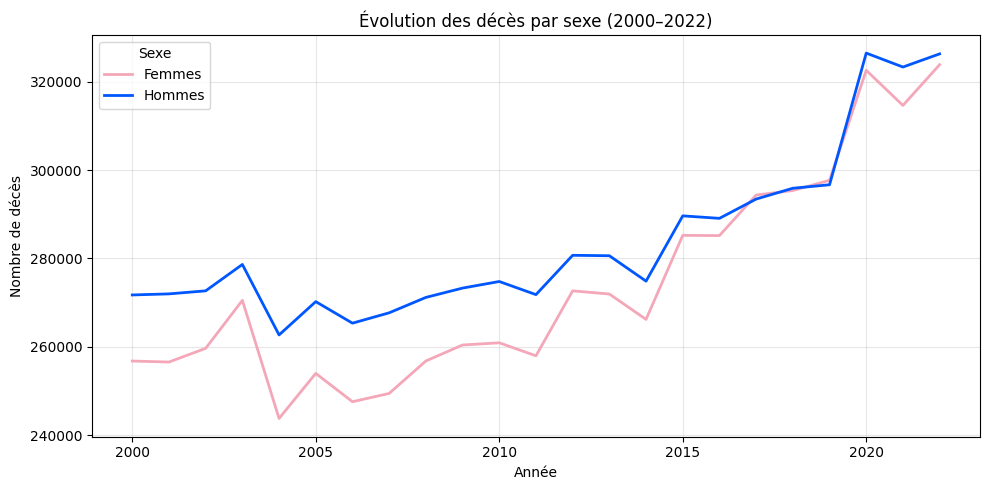

In [7]:

YEAR_COL = "Year"

# Somme annuelle des décès par sexe
dec = df.groupby(YEAR_COL)[["D_F", "D_H"]].sum().sort_index()

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(dec.index, dec["D_F"], 
         label="Femmes", 
         linewidth=2, 
         color="#F4A7B9")   # rose clair

# Hommes en bleu
plt.plot(dec.index, dec["D_H"], 
         label="Hommes", 
         linewidth=2, 
         color="#0057FF")   # bleu vif

plt.title("Évolution des décès par sexe (2000–2022)")
plt.xlabel("Année")
plt.ylabel("Nombre de décès")
plt.grid(True, alpha=0.3)
plt.legend(title="Sexe")
plt.tight_layout()
plt.show()


**Interprétation :**  
On observe une progression globale du nombre de décès pour les deux sexes, particulièrement marquée après **2014**. À partir de **2018**, la mortalité masculine dépasse régulièrement la féminine, traduisant un **vieillissement simultané mais différencié** de la population.  
Un **pic** est visible autour de **2020–2021**, probablement lié à la crise sanitaire.


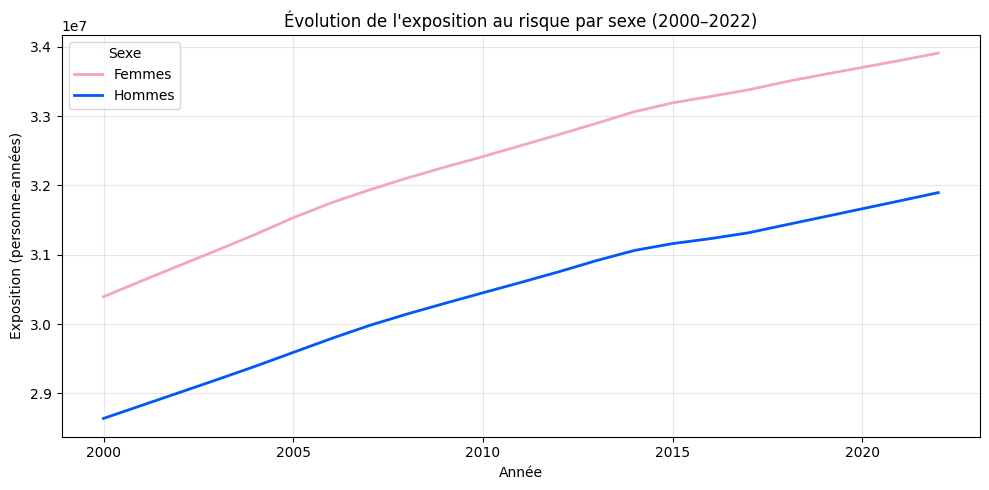

In [8]:

YEAR_COL = "Year"  

# Somme annuelle des expositions par sexe
expo = df.groupby(YEAR_COL)[["E_F", "E_H"]].sum().sort_index()

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(expo.index, expo["E_F"],
         label="Femmes",
         linewidth=2,
         color="#F4A7B9")

# Hommes en bleu
plt.plot(expo.index, expo["E_H"],
         label="Hommes",
         linewidth=2,
         color="#0057FF")

plt.title("Évolution de l'exposition au risque par sexe (2000–2022)")
plt.xlabel("Année")
plt.ylabel("Exposition (personne-années)")
plt.grid(True, alpha=0.3)
plt.legend(title="Sexe")
plt.tight_layout()
plt.show()


**Interprétation :**  
L’exposition augmente régulièrement sur l’ensemble de la période, traduisant un **allongement de la durée de vie** dans la population.  
Les femmes présentent une exposition systématiquement **plus élevée**, ce qui reflète leur **espérance de vie plus longue** et leur **surreprésentation aux âges avancés**.


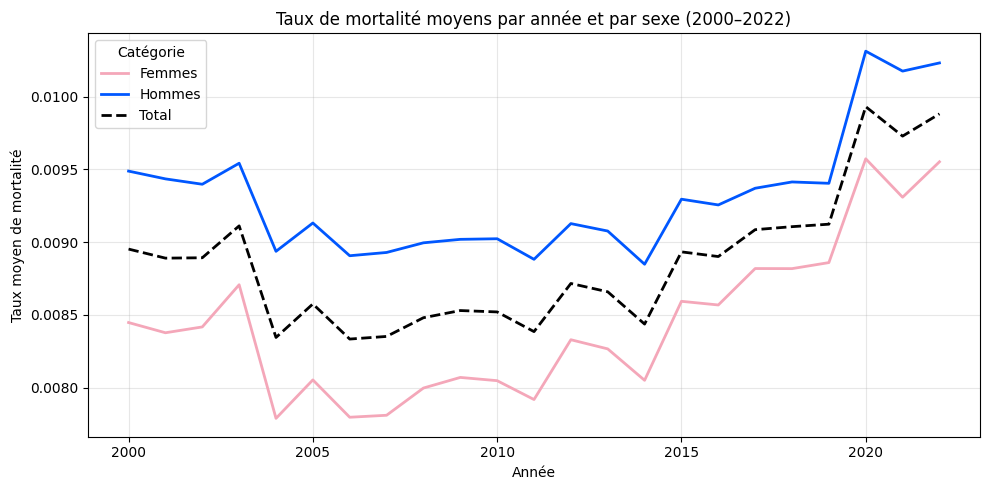

In [9]:


YEAR_COL = "Year" 

# Agrégation annuelle (ratio des sommes)
grp = df.groupby(YEAR_COL).agg({
    "D_F": "sum", "E_F": "sum",
    "D_H": "sum", "E_H": "sum"
}).sort_index()

mF = grp["D_F"] / grp["E_F"]
mH = grp["D_H"] / grp["E_H"]
mT = (grp["D_F"] + grp["D_H"]) / (grp["E_F"] + grp["E_H"])

plt.figure(figsize=(10,5))

# Femmes en rose
plt.plot(mF.index, mF.values,
         label="Femmes",
         linewidth=2,
         color="#F4A7B9")

# Hommes en bleu
plt.plot(mH.index, mH.values,
         label="Hommes",
         linewidth=2,
         color="#0057FF")

# Total en noir pointillé
plt.plot(mT.index, mT.values,
         label="Total",
         linewidth=2,
         color="#000000",
         linestyle="--")

plt.title("Taux de mortalité moyens par année et par sexe (2000–2022)")
plt.xlabel("Année")
plt.ylabel("Taux moyen de mortalité")
plt.grid(True, alpha=0.3)
plt.legend(title="Catégorie")
plt.tight_layout()
plt.show()


**Interprétation :**  
On constate une **baisse progressive** des taux de mortalité moyens, plus nette chez les femmes que chez les hommes.  
La mortalité masculine reste significativement **plus élevée** durant toute la période.  
Les **variations récentes en dents de scie** illustrent des effets exogènes ponctuels, comme la pandémie.


### 3 - Profil de mortalité par age :

L’analyse du profil de mortalité en fonction de l’âge permet de mieux comprendre les dynamiques démographiques sous-jacentes. En effet, le taux de mortalité *m(x)* varie considérablement selon l’âge, et sa forme est révélatrice des structures sanitaires et sociales d’une population.

Nous étudions ici les **courbes de mortalité par âge** pour les années **2000, 2010 et 2020**, en distinguant **hommes** et **femmes**.  
Ces profils sont tracés sur une **échelle logarithmique**, conformément aux pratiques actuarielles, afin de mieux visualiser les écarts sur plusieurs ordres de grandeur.


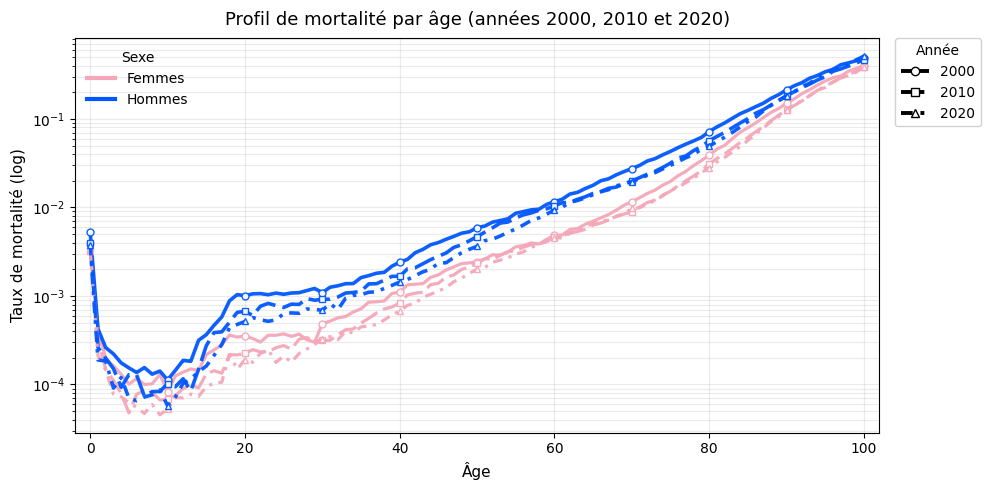

In [10]:
YEAR_COL = "Year"
AGE_COL  = "Age"

# Couleurs sexe
color_f, color_h = "#F4A7B9", "#0057FF"

# Styles années (traits TRÈS distincts) + marqueurs
dash = {
    2000: (0, (1, 0)),           # plein
    2010: (0, (6, 2)),           # tirets longs
    2020: (0, (3, 2, 1, 2)),     # tirets-points
}
markers = {2000: "o", 2010: "s", 2020: "^"}

years = [2000, 2010, 2020]

# Calcul m_F/m_H si besoin
if "m_F" not in df.columns and {"D_F","E_F"}.issubset(df.columns):
    df["m_F"] = df["D_F"] / df["E_F"]
if "m_H" not in df.columns and {"D_H","E_H"}.issubset(df.columns):
    df["m_H"] = df["D_H"] / df["E_H"]

sub = df[df[YEAR_COL].isin(years)].dropna(subset=[AGE_COL, "m_F", "m_H"]).copy()

fig, ax = plt.subplots(figsize=(10,5))

# Courbes par année + sexe (mêmes couleurs; styles/markers par année)
for y in years:
    d = sub[sub[YEAR_COL] == y].sort_values(AGE_COL)
    # Femmes
    ax.plot(
        d[AGE_COL], d["m_F"],
        color=color_f, linestyle=dash[y], linewidth=2.3, alpha=0.95,
        marker=markers[y], markevery=10, markersize=5, markerfacecolor="white"
    )
    # Hommes
    ax.plot(
        d[AGE_COL], d["m_H"],
        color=color_h, linestyle=dash[y], linewidth=2.6, alpha=0.95,
        marker=markers[y], markevery=10, markersize=5, markerfacecolor="white"
    )

# Mise en forme
ax.set_yscale("log")
ax.grid(True, which="both", alpha=0.25)
ax.set_xlabel("Âge", fontsize=11)
ax.set_ylabel("Taux de mortalité (log)", fontsize=11)
ax.set_title("Profil de mortalité par âge (années 2000, 2010 et 2020)", fontsize=13, pad=10)
ax.tick_params(axis="both", labelsize=10)
ax.margins(x=0.02, y=0.05)

# Légende SEXE (couleurs)
sex_handles = [
    Line2D([0],[0], color=color_f, lw=3, label="Femmes"),
    Line2D([0],[0], color=color_h, lw=3, label="Hommes"),
]
leg1 = ax.legend(
    handles=sex_handles, title="Sexe",
    loc="upper left", frameon=False
)
ax.add_artist(leg1)

# Légende ANNÉE (traits + marqueurs clairs, à droite, encadré)
year_handles = [
    Line2D([0],[0],
           color="black", lw=2.8, linestyle=dash[y],
           marker=markers[y], markersize=6, markerfacecolor="white",
           label=str(y))
    for y in years
]
leg2 = ax.legend(
    handles=year_handles, title="Année",
    loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0,
    frameon=True, fancybox=True
)
leg2.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


**Interprétation :**  
Le profil de mortalité présente une forme typique en **“U” inversé** :

- Une mortalité très élevée à la naissance (*x = 0*), suivie d’une chute rapide.  
- Une phase de **plateau minimal** vers les âges 5 à 15 ans, zone de plus faible risque vital.  
- Une **croissance exponentielle** à partir de 30–40 ans, qui s’accélère nettement après 60 ans.

Les courbes montrent systématiquement une **surmortalité masculine** à tout âge, avec un écart particulièrement marqué aux âges intermédiaires et avancés.  
L’évolution entre les années révèle une **amélioration progressive des taux de mortalité**, en particulier pour les jeunes adultes.  
Cette baisse est visible dans le déplacement vers le bas des courbes entre **2000 et 2020**.

L’utilisation de l’**échelle logarithmique** met en évidence les rapports multiplicatifs entre les sexes et les années, notamment aux jeunes âges où les différences, bien que faibles en valeur absolue, sont significatives en proportion.


### 4 - Analyse croisée age-année :

Au-delà des profils par âge ou par année, une représentation conjointe des deux dimensions permet de mieux saisir les dynamiques croisées de la mortalité. La carte thermique suivante illustre l’évolution du taux de mortalité agrégé **m(t, x)**, selon l’âge (ordonnée) et l’année (abscisse). Ce type de visualisation est particulièrement utile pour repérer des discontinuités ou des ruptures dans le temps, notamment celles liées à des chocs sanitaires.


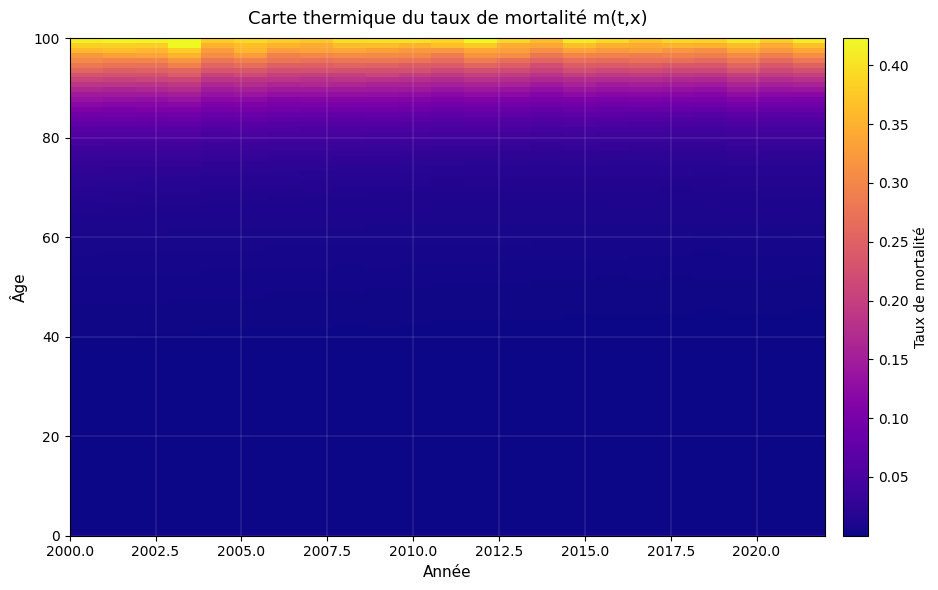

In [11]:


# === 1) Paramètres colonnes ===============================
YEAR_COL = "Year"     # année
AGE_COL  = "Age"      # âge
D_F_COL, D_H_COL = "D_F", "D_H"
E_F_COL, E_H_COL = "E_F", "E_H"
M_TOT_COL = "m_Tot"   # si présent, on l'utilise directement

# === 2) Calcul du taux m(t,x) agrégé par âge & année ========================
df_cal = df.copy()

# Si m_Tot absent, on le calcule (ratio des D totaux sur E totales)
if M_TOT_COL not in df_cal.columns:
    if {D_F_COL, D_H_COL, E_F_COL, E_H_COL}.issubset(df_cal.columns):
        df_cal["D_Tot"] = df_cal[D_F_COL].astype(float) + df_cal[D_H_COL].astype(float)
        df_cal["E_Tot"] = df_cal[E_F_COL].astype(float) + df_cal[E_H_COL].astype(float)
        # éviter division par 0
        df_cal.loc[df_cal["E_Tot"] <= 0, "E_Tot"] = np.nan
        df_cal["m_Tot"] = df_cal["D_Tot"] / df_cal["E_Tot"]
    else:
        raise ValueError("Colonne m_Tot absente et colonnes D_/E_ manquantes pour le calcul.")

# On garde uniquement les colonnes utiles et lignes valides
z = df_cal[[YEAR_COL, AGE_COL, "m_Tot"]].dropna()

# Option : tronquer à des bornes raisonnables pour l’échelle des couleurs
z["m_Tot"] = z["m_Tot"].clip(lower=0, upper=z["m_Tot"].quantile(0.999))

# === 3) Mise en grille (pivot : lignes=Âge, colonnes=Année) ==================
mat = z.pivot_table(index=AGE_COL, columns=YEAR_COL, values="m_Tot", aggfunc="mean")
mat = mat.sort_index(axis=0).sort_index(axis=1)  # trier âge et année

ages  = mat.index.values
years = mat.columns.values
data  = mat.values

# === 4) Tracé de la heatmap =================================
fig, ax = plt.subplots(figsize=(10, 6))

# extent pour des axes en vraies unités (années/âges)
extent = [years.min(), years.max(), ages.min(), ages.max()]

# colormap 
im = ax.imshow(
    data,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="plasma",
    interpolation="nearest",   # blocs nets; mets "bilinear" si tu veux lissage
    norm=Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
)

# Axes et titres 
ax.set_title("Carte thermique du taux de mortalité m(t,x)", fontsize=13, pad=10)
ax.set_xlabel("Année", fontsize=11)
ax.set_ylabel("Âge", fontsize=11)

# Grille légère pour la lisibilité
ax.grid(color="white", linestyle="-", linewidth=0.2, alpha=0.6)

# Barre de couleurs
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Taux de mortalité", fontsize=10)

# Ajustements
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


**Interprétation :**  
La carte révèle la structure classique de la mortalité :

- Des taux très faibles pour les âges jeunes (partie inférieure violette) ;
- Une augmentation progressive à partir de 40–50 ans ;
- Des taux très élevés (couleurs jaunes) pour les âges supérieurs à 85–90 ans, atteignant parfois 40 à 50 %.

L’intensité de la couleur jaune en haut à droite (années 2020–2021 pour les âges avancés) trahit un **effet net du COVID-19**, avec une hausse anormale des taux de mortalité chez les seniors par rapport aux années précédentes.  
Cette visualisation met également en évidence la régularité des profils de mortalité dans les années précédentes, renforçant la pertinence de modèles de projection longitudinaux.


### 5 - Comparaison Hommes-Femmes :

L’un des phénomènes structurels les plus bien documentés en démographie est la **surmortalité masculine**, observée à presque tous les âges.  
Pour mieux quantifier cette inégalité, nous analysons ici deux indicateurs comparatifs :

- La différence Δm(x) = *mₕ(x)* − *m𝒻(x)*, calculée pour chaque âge puis moyennée sur toutes les années ;
- Le ratio *mₕ(t, x)* / *m𝒻(t, x)*, observé simultanément par âge et année, et représenté sous forme de **carte thermique**.


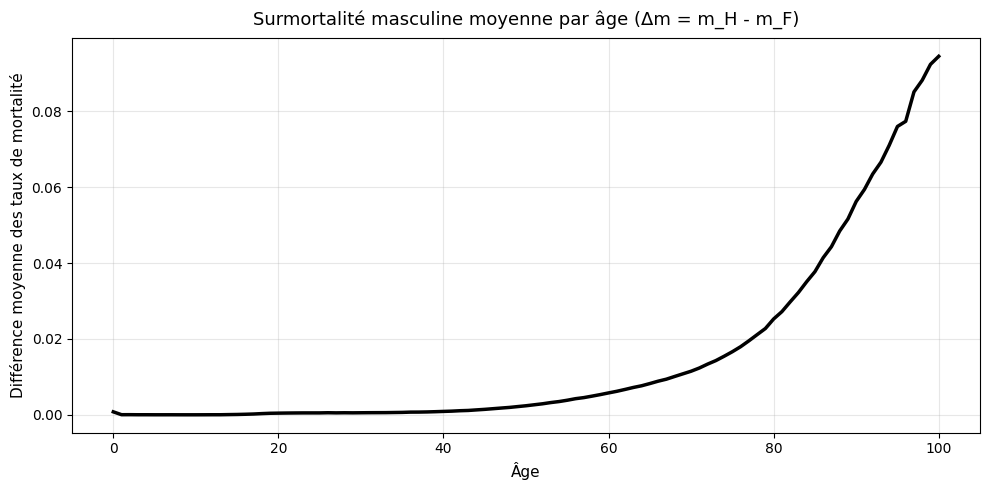

In [12]:
AGE_COL = "Age" 

# 1) Moyenne des taux par âge (toutes années confondues)
by_age = (
    df
    .groupby(AGE_COL)[["m_H", "m_F"]]
    .mean()
    .sort_index()
)

# 2) Surmortalité masculine Δm(x) = m_H - m_F
by_age["Delta_m"] = by_age["m_H"] - by_age["m_F"]

# 3) Tracé
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    by_age.index,
    by_age["Delta_m"],
    color="black",          # courbe noire
    linewidth=2.5
)

ax.set_title("Surmortalité masculine moyenne par âge (Δm = m_H - m_F)", fontsize=13, pad=10)
ax.set_xlabel("Âge", fontsize=11)
ax.set_ylabel("Différence moyenne des taux de mortalité", fontsize=11)

ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

**Interprétation :**  
Cette courbe montre que la surmortalité masculine est quasi inexistante aux très jeunes âges, mais augmente fortement à partir de 40 ans. La différence dépasse **2 %** au-delà de 80 ans et atteint un maximum de près de **9 %** autour de 100 ans.  
Cette dynamique est liée à la fois à des facteurs biologiques et comportementaux, et reflète une longévité structurellement plus faible chez les hommes.


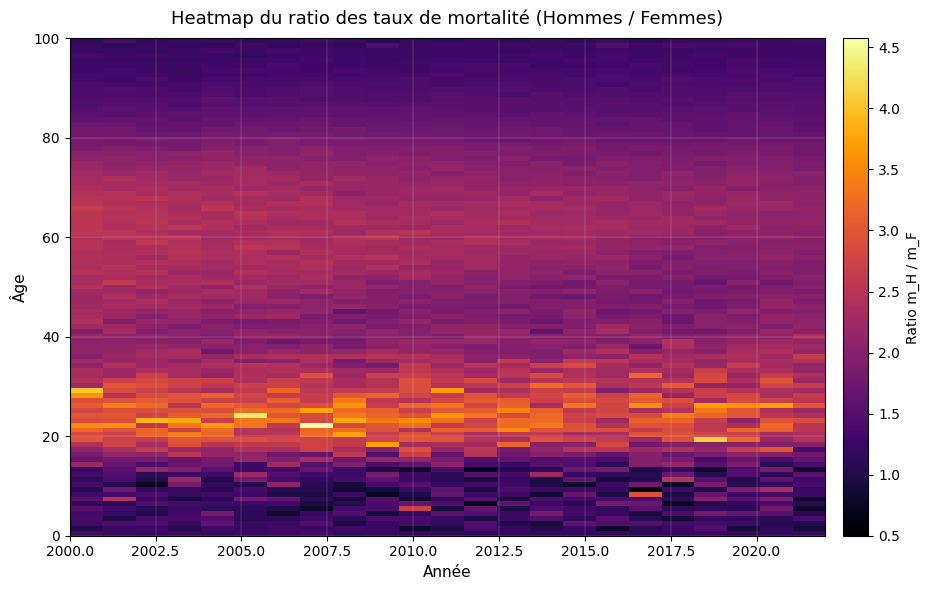

In [13]:

# === 1) Noms de colonnes (adapte si besoin) ===============================
YEAR_COL = "Year"
AGE_COL  = "Age"

# === 2) Calcul du ratio m_H / m_F ========================================
df_ratio = df.copy()

# éviter division par zéro : on met NaN quand m_F <= 0
df_ratio.loc[df_ratio["m_F"] <= 0, "m_F"] = np.nan
df_ratio["ratio_HF"] = df_ratio["m_H"] / df_ratio["m_F"]

# on enlève les lignes sans ratio valide
z = df_ratio[[YEAR_COL, AGE_COL, "ratio_HF"]].dropna()

# option : tronquer les valeurs extrêmes pour une échelle de couleur lisible
z["ratio_HF"] = z["ratio_HF"].clip(lower=0.5, upper=5)

# === 3) Mise en grille : lignes = Âge, colonnes = Année ==================
mat = z.pivot_table(
    index=AGE_COL,
    columns=YEAR_COL,
    values="ratio_HF",
    aggfunc="mean"
).sort_index(axis=0).sort_index(axis=1)

ages  = mat.index.values
years = mat.columns.values
data  = mat.values

# === 4) Tracé de la heatmap =============================================
fig, ax = plt.subplots(figsize=(10, 6))

extent = [years.min(), years.max(), ages.min(), ages.max()]

im = ax.imshow(
    data,
    aspect="auto",
    origin="lower",
    extent=extent,
    cmap="inferno",  # violet -> jaune, proche de ton exemple
    interpolation="nearest",
    norm=Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))
)

ax.set_title("Heatmap du ratio des taux de mortalité (Hommes / Femmes)", fontsize=13, pad=10)
ax.set_xlabel("Année", fontsize=11)
ax.set_ylabel("Âge", fontsize=11)

ax.grid(color="white", linestyle="-", linewidth=0.2, alpha=0.6)

# Barre de couleurs
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Ratio m_H / m_F", fontsize=10)

ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()


**Interprétation :**  
La carte thermique confirme l’ampleur et la stabilité de la surmortalité masculine sur la période étudiée. On note un **pic entre 20 et 35 ans** avec des ratios supérieurs à 3 voire 4, ce qui s’explique par des comportements à risque plus fréquents chez les hommes (accidents, comportements violents, toxicomanies).  
Ce ratio diminue aux âges élevés, mais reste systématiquement supérieur à 1, confirmant la vulnérabilité accrue des hommes à presque tous les âges.

### 6 - Méthodes complémentaires d'analyse exploratoire :

Afin d’enrichir l’analyse descriptive et de préparer la phase de modélisation, nous mobilisons ici deux outils complémentaires : la **variabilité relative** des taux de mortalité et l’**analyse de corrélation** entre âge et risque de décès.  
Le premier indicateur étudié est le **coefficient de variation (CV)** des taux de mortalité par tranche d’âge, défini comme le rapport *écart-type / moyenne*. Il permet d’identifier les classes d’âge où les taux sont les plus instables et où une modélisation prudente est nécessaire.


/tmp/ipykernel_13807/896452461.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("Tranche_age")[MORT_COL]


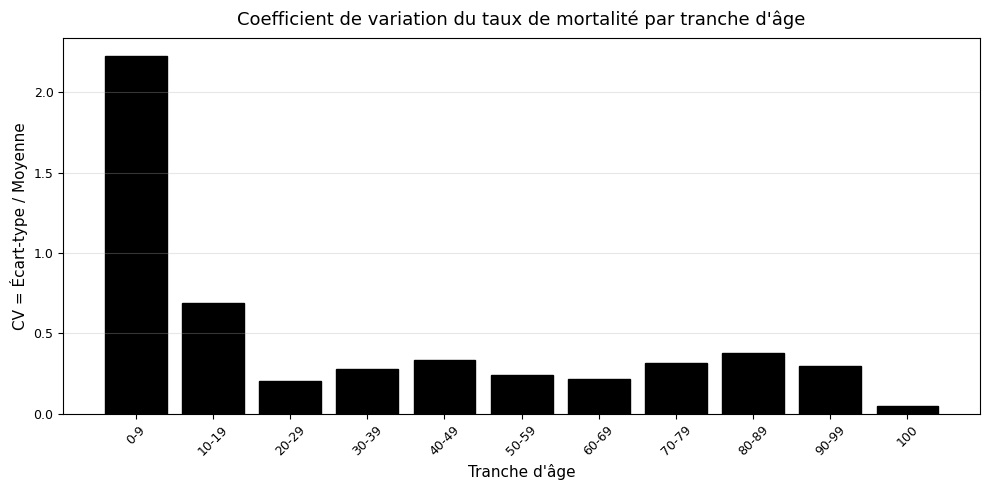

In [15]:

# Colonnes à adapter si besoin
AGE_COL  = "Age"
MORT_COL = "m_Tot"   # taux de mortalité agrégé

# 1) Construction des tranches d'âge
bins   = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ["0-9", "10-19", "20-29", "30-39", "40-49",
          "50-59", "60-69", "70-79", "80-89", "90-99", "100"]

df = df.copy()
df["Tranche_age"] = pd.cut(df[AGE_COL], bins=bins, labels=labels, right=False)

# 2) Coefficient de variation CV = std / mean par tranche
grp = df.groupby("Tranche_age")[MORT_COL]
cv = (grp.std() / grp.mean()).dropna()

# 3) Tracé en barres NOIR
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(cv.index.astype(str), cv.values,
       color="black", edgecolor="black")

ax.set_title("Coefficient de variation du taux de mortalité par tranche d'âge",
             fontsize=13, pad=10)
ax.set_xlabel("Tranche d'âge", fontsize=11)
ax.set_ylabel("CV = Écart-type / Moyenne", fontsize=11)

ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="both", labelsize=9)

plt.tight_layout()
plt.show()

**Interprétation :**  
Le coefficient de variation est **très élevé** chez les enfants de 0 à 9 ans (supérieur à 2), ce qui traduit une instabilité importante des taux de mortalité à ces âges.  
À partir de 20 ans, la variabilité devient nettement plus faible : les taux sont plus stables, avec un CV généralement compris entre **0,2 et 0,4**.  
Cette information est précieuse pour la modélisation : les tranches d’âge jeunes nécessitent une **prudence particulière** (choix de modèles spécifiques, pondération adaptée), tandis que les tranches adultes et âgées offrent des profils plus réguliers.```


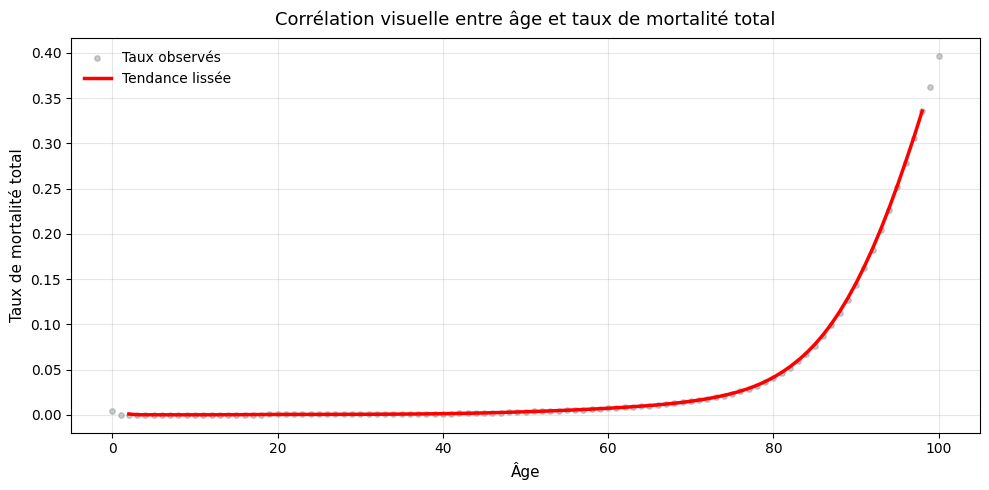

In [16]:
AGE_COL  = "Age"
MORT_COL = "m_Tot"

# 1) Moyenne du taux de mortalité total par âge
by_age = (
    df
    .groupby(AGE_COL)[MORT_COL]
    .mean()
    .reset_index()
    .sort_values(AGE_COL)
)

ages = by_age[AGE_COL].values
mtot = by_age[MORT_COL].values

# 2) Courbe lissée simple (moyenne mobile)
window = 5  # taille de la fenêtre pour lisser (à ajuster si besoin)
mtot_smooth = pd.Series(mtot).rolling(window, center=True).mean().to_numpy()

# 3) Tracé
fig, ax = plt.subplots(figsize=(10, 5))

# Nuage de points (gris)
ax.scatter(ages, mtot, color="grey", alpha=0.4, s=15, label="Taux observés")

# Courbe lissée (rouge)
ax.plot(ages, mtot_smooth, color="red", linewidth=2.5, label="Tendance lissée")

ax.set_title("Corrélation visuelle entre âge et taux de mortalité total",
             fontsize=13, pad=10)
ax.set_xlabel("Âge", fontsize=11)
ax.set_ylabel("Taux de mortalité total", fontsize=11)

ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=10)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Interprétation :**  
Le graphique montre une relation fortement croissante entre l’âge et le taux de mortalité, avec une pente particulièrement marquée après 60 ans.  
La courbe lissée suit une dynamique exponentielle classique, ce qui justifie pleinement l’usage de modèles paramétriques ou semi-paramétriques où l’âge joue le rôle de variable explicative principale.

### 7 - Synthèse descriptive générale :

L’analyse descriptive menée dans cette première partie a permis de dresser un portrait statistique complet de la mortalité dans la population française entre 2000 et 2022. Plusieurs enseignements majeurs peuvent être retenus :

- **Structure globale :**  
  Les taux de mortalité présentent une distribution très asymétrique selon l’âge, avec des valeurs extrêmement faibles chez les jeunes et une croissance rapide après 60 ans. Les statistiques descriptives ont confirmé l’ordre de grandeur des variables d’exposition, des décès et des mortalités, ainsi que leur dispersion.

- **Évolution temporelle :**  
  L’analyse des séries chronologiques a révélé une tendance générale à la baisse des taux de mortalité moyens au cours des deux dernières décennies, avec une rupture nette en 2020–2021 liée à l’effet COVID-19. Les expositions sont en hausse continue, traduisant l’allongement de la durée de vie.

- **Profil par âge :**  
  Le profil de mortalité par âge suit une forme en “U” inversé logarithmique, typique des modèles actuarielles : mortalité élevée à la naissance, plateau minimal aux âges scolaires, puis croissance exponentielle aux grands âges.

- **Comparaisons hommes / femmes :**  
  La surmortalité masculine est structurelle, présente à tous les âges, avec un différentiel maximal autour de 20 à 40 ans (ratios supérieurs à 3). La différence \( m_H - m_F \) devient très significative au-delà de 70 ans.

- **Méthodes complémentaires :**  
  Le coefficient de variation a mis en évidence une forte instabilité relative des taux de mortalité aux jeunes âges. La forte corrélation entre âge et taux de mortalité total valide le choix de l’âge comme variable centrale dans la modélisation.


L’ensemble des résultats obtenus dans la partie descriptive fournit un socle empirique solide pour aborder la phase de modélisation.  
Les analyses menées ont permis d’identifier les caractéristiques essentielles de la mortalité au sein de la population étudiée :

- une structure fortement dépendante de l’âge, avec une dynamique exponentielle aux grands âges ;
- des différences marquées entre hommes et femmes, révélatrices de comportements et facteurs biologiques différenciés ;
- des ruptures temporelles significatives, notamment autour de 2020–2021 en lien avec la pandémie ;
- des zones d’instabilité statistique identifiées via le coefficient de variation ;
- une corrélation nette et robuste entre âge et taux de mortalité total.

Ces constats confirment la nécessité d’utiliser des **modèles paramétriques ou semi-paramétriques** intégrant explicitement l’âge et, éventuellement, le temps, afin de capturer correctement les tendances observées.  

Dans la section suivante, nous présentons les principaux modèles de projection utilisés en démographie et en actuariat — notamment le **modèle de Lee–Carter**, ainsi que des approches issues de l’apprentissage automatique — et nous évaluons leur capacité à reproduire et anticiper les profils de mortalité observés.
